Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36
N_IMAGES = 13143

In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 0.996078431372549
0.0 0.99607843
0.0 1.0


In [6]:
gan_data[2]

{'Pictures': array([0.61839616, 0.44413477, 0.29612473, ..., 0.39931136, 0.31908587,
        0.2899297 ], dtype=float32)}

# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [7]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, n_clusters=25):
    cluster_data = np.vstack([generated_data, real_data])
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10)
    labels = kmeans.fit(cluster_data).labels_
    
    generated_labels = labels[:len(generated_data)]
    real_labels = labels[len(generated_data):]

    gen_density = np.histogram(generated_labels, bins=n_clusters,
                               range=[0, n_clusters], density=True)[0]
    real_density = np.histogram(real_labels, bins=n_clusters,
                                range=[0, n_clusters], density=True)[0]
    
    return real_density, gen_density

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [8]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    slopes = np.tan(angles)
    slopes_2d = np.expand_dims(slopes, 1)
    
    real_density_2d = np.expand_dims(real_density, 0)
    gen_density_2d = np.expand_dims(gen_density, 0)
    
    precision = np.minimum(real_density_2d*slopes_2d, gen_density_2d).sum(axis=1)
    recall = precision / slopes

    return precision, recall

For stability, take the average of several repetitions

In [9]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    return vectors

## 2. Apply it##

In [10]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [11]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

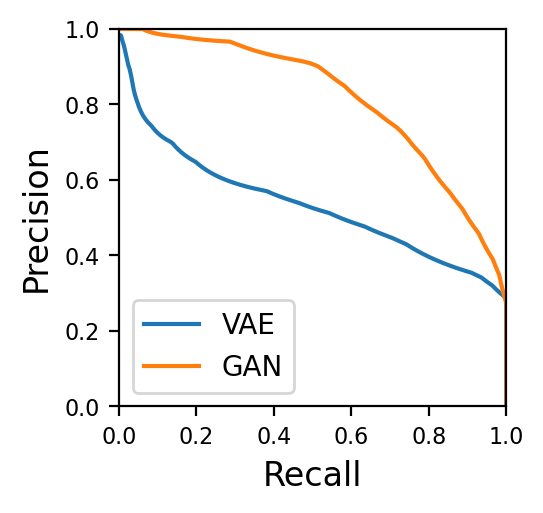

In [12]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**Q: What curves were obtained for the first (VAE) and the second (GAN) models? What can we say about the advantages and disadvantages of each model?**

A: Looking at the Precision-Recall curves, we can assume that GAN was more successful at generating face images closer to the real faces. However, looking at GAN's images, one can see different artifacts, while VAE images are smooth and clear. VAE trains way faster and more stable than GAN, but does not achieve the level of "realness" of the faces that GAN has.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [13]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms

In [14]:
class InceptionWrapper(nn.Module):
    """Feature Extractor based on the 1st part of InceptionNet """
    
    def __init__(self):
        super(InceptionWrapper, self).__init__()
        self.model = models.inception_v3(pretrained=True)
        del self.model.fc
        
    def forward(self, x):
        x = self.model.Conv2d_1a_3x3(x)
        x = self.model.Conv2d_2a_3x3(x)
        x = self.model.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.model.Conv2d_3b_1x1(x)
        x = self.model.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.model.Mixed_5b(x)
        x = self.model.Mixed_5c(x)
        x = self.model.Mixed_5d(x)
        x = torch.flatten(x, 1)
        return x
    
    
feature_extractor = InceptionWrapper()

In [15]:
x = torch.rand(1, CHANNEL_NUM, PICTURE_SIZE, PICTURE_SIZE)
output = feature_extractor(x)
print('Feature space # dimensions: {}'.format(output.shape[1]))

Feature space # dimensions: 1152


In [16]:
real_data_input = torch.from_numpy(real_data.image.reshape((N_IMAGES, PICTURE_SIZE, PICTURE_SIZE, CHANNEL_NUM)).transpose(0, 3, 1, 2))
vae_data_input = torch.from_numpy(vae_data.image.reshape((N_IMAGES, PICTURE_SIZE, PICTURE_SIZE, CHANNEL_NUM)).transpose(0, 3, 1, 2))
gan_data_input = torch.from_numpy(gan_data.image.reshape((N_IMAGES, PICTURE_SIZE, PICTURE_SIZE, CHANNEL_NUM)).transpose(0, 3, 1, 2))

In [17]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [18]:
for i in range(N_IMAGES):
    real_data_input[i] = normalize(real_data_input[i])
    vae_data_input[i] = normalize(vae_data_input[i])
    gan_data_input[i] = normalize(gan_data_input[i])

In [19]:
with torch.no_grad():
    real_data_space = feature_extractor(real_data_input.float())
    del real_data_input

In [20]:
with torch.no_grad():
    vae_data_space = feature_extractor(vae_data_input.float())
    del vae_data_input

In [21]:
with torch.no_grad():
    gan_data_space = feature_extractor(gan_data_input.float())
    del gan_data_input

In [23]:
a, b = bin_counts(real_data_space, vae_data_space)
c, d = bin_counts(real_data_space, gan_data_space)

In [24]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

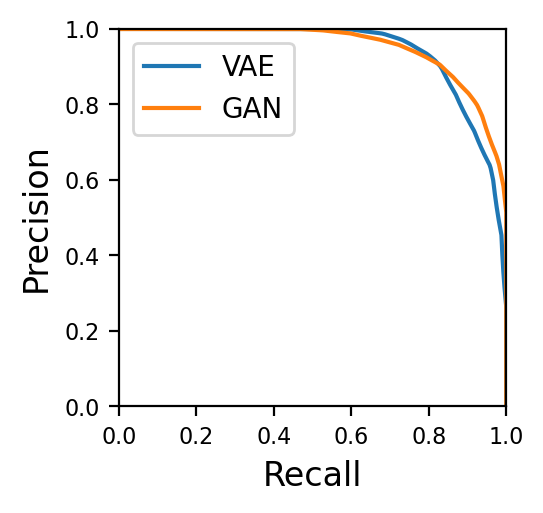

In [25]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()